# Coaquisitions analyses binned by length of recipient-branch

In [1]:
data_dir = '../data/'
taxonomic_id = '1236'
compiled_res_dir = '../data/compiled_results/'
plots_dir = '../plots/'

In [2]:
# to suppress warning from ete3 because it's not up to date with py3.12
import warnings

# ignore SyntaxWarning
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib as mpl
import ete3

# use plotly for interactive plots
from plotly.offline import plot
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import math

import json
# read in the marker styles
with open('lib/plot_marker_styles.json', 'r') as f:
    marker_styles_dict = json.load(f)['marker_styles_dict']
    # this is a dictionary such that for each method it contains
    # a dict of marker styles for 'pyplot', 'plotly', 'marker_color', 'face_color'

# set global pyplot font to be serif
plt.rcParams["font.family"] = "serif"

neighbor_genes_between_cutoffs = [1]
minimum_genome_size = 1000  # minimum genome size to consider a genome (i.e. contig or chromosome) for analysis
min_coacquisitions = 20  # minimum number of coacquisitions to consider a threshold of a method for analysis
# minimum number of coacquisitions with known positions, as a certain numerator, for considering it for percentage calculation
# e.g. for the percentage of coacquisitions that are neighbors,
# we need at least this meany neighbors that are coacquired for a given transfer threshold of a method to be considered
min_numerator = 0  # if 0, then in paper we add notes about the fact that there may be small number effects

In [4]:
import importlib


# reload the library in case it has been updated
if "clsl" in globals():
    importlib.reload(clsl)
from lib import coacq_logscale_summary_lib as clsl

In [5]:
# Scale the relevant rcParams by 1.5x, but use font_scale_factor for font sizes
scale_factor = 1.5
font_scale_factor = 2.5
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        # Use font_scale_factor if the key is related to font size
        if "font" in key:
            factor = font_scale_factor
        else:
            factor = scale_factor
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

,recipient_branch,branch_length
0,1896966,0.707034
1,381306,0.298287
2,1810504,0.263150
3,246195,0.206865
4,797473,0.179588


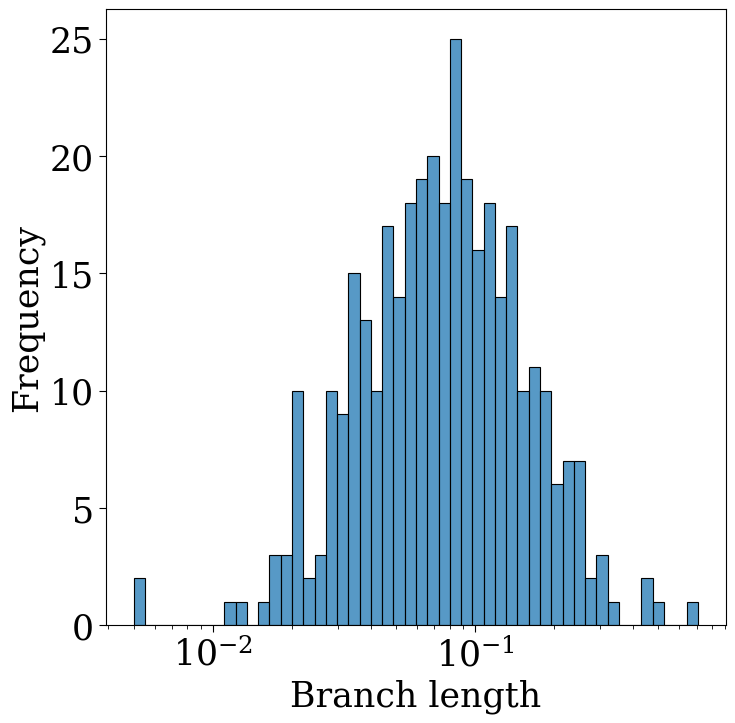

Short bin: 0.07552, Long bin: 0.707034
Number of short branches: 180
 Number of long branches: 180
 Total number of branches: 359


In [6]:
# read in the genome tree
# to prepare a map of recipient branch id to branch length
genome_tree_filepath = f"{
    data_dir}/{taxonomic_id}_wol_tree_pruned_with_internal_labels.nwk"
# read in with ete3
genome_tree = ete3.Tree(genome_tree_filepath, format=1)
# prepare a map of recipient branch id to branch length
rec_branch_length_dict = {
    node.name: node.dist for node in genome_tree.traverse() if node.is_leaf()
}
rec_branch_length_df = pd.DataFrame.from_dict(
    rec_branch_length_dict, orient="index", columns=["branch_length"]
).reset_index(names="recipient_branch")
display(rec_branch_length_df.head())
# plot the distribution of branch lengths
branch_lengths = [node.dist for node in genome_tree.traverse() if node.is_leaf()]
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(
    branch_lengths,
    bins=50,
    log_scale=True,
    ax=ax,
)
plt.xlabel("Branch length")
plt.ylabel("Frequency")
plt.show()

# bin the branches by terciles of branch lengths
# the bins are equally spaced (similar number of NOGs in each bin, not in logspace)
total_num_branches = len(branch_lengths)
short_bin = float(np.percentile(branch_lengths, 50))
# medium_bin = float(np.percentile(branch_lengths, 66))
long_bin = float(np.percentile(branch_lengths, 100))
print(f"Short bin: {short_bin}, Long bin: {long_bin}")
short_branches = rec_branch_length_df[
    rec_branch_length_df["branch_length"].between(0, short_bin)
]
# medium_branches = rec_branch_length_df[
#     rec_branch_length_df["branch_length"].between(short_bin, medium_bin)
# ]
long_branches = rec_branch_length_df[
    rec_branch_length_df["branch_length"].between(short_bin, long_bin)
]
# add a column to the dataframe with the bin
def get_bin(row):
    if row["branch_length"] <= short_bin:
        return "short"
    # elif row["branch_length"] <= medium_bin:
    #     return "medium"
    else:
        return "long"
rec_branch_length_df["bin"] = rec_branch_length_df.apply(get_bin, axis=1)
# print the number of branches in each bin
print(
    f"Number of short branches: {len(short_branches)}\n",
    # f"Number of medium branches: {len(medium_branches)}\n",
    f"Number of long branches: {len(long_branches)}\n",
    f"Total number of branches: {total_num_branches}"
)

In [7]:
# now we perform the neighboring co-acquisitions analysis but for the binned branch lengths
# read in the data: chromosome locations, and coacquisitions for each method
coacquisitions_dfs = clsl.load_data(compiled_res_dir)
# for each method, find the minimum number of transfers under different transfer thresholds
coacquisitions_dfs = clsl.calculate_min_transfers(coacquisitions_dfs)

# the following methods have manually set thresholds (gain-loss penalty ratios or MAD values)
methods_for_manual_thresholds = [
    "count_mp",
    "gloome_mp",
    "gloome_mp.without_tree",
    "wn",
]
manual_threshold_coacquisitions_dfs_dict = {}
for meth in methods_for_manual_thresholds:
    # read in the data
    manual_threshold_coacquisitions_dfs_dict[meth] = clsl.load_data(
        os.path.join(compiled_res_dir, meth.split(".")[0]),
        include_manual_thresholds=True
    )
    # calculate the minimum number of transfers
    manual_threshold_coacquisitions_dfs_dict[meth] = clsl.calculate_min_transfers(
        manual_threshold_coacquisitions_dfs_dict[meth]
    )



The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger-fast', 'ranger', 'count.ml', 'wn']
The following methods are included in the coacquisitions data:
['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.2', 'count.mp.3', 'count.mp.4', 'count.mp.5', 'count.mp.6', 'count.mp.7', 'count.mp.8']
The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.2', 'gloome.mp.3', 'gloome.mp.4', 'gloome.mp.5', 'gloome.mp.6', 'gloome.mp.7', 'gloome.mp.8', 'gloome.mp.without_tree.0.33', 'gloome.mp.without_tree.0.5', 'gloome.mp.without_tree.1', 'gloome.mp.without_tree.2', 'gloome.mp.without_tree.3', 'gloome.mp.without_tree.4', 'gloome.mp.without_tree.5', 'gloome.mp.without_tree.6', 'gloome.mp.without_tree.7', 'gloome.mp.without_tree.8']
The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.

In [8]:
# summarize the coacquisitions for each method across transfer thresholds
def summarize_coacquisitions_for_bins(
    coacquisitions_dfs,
    neighbor_genes_between_cutoffs,
    minimum_genome_size,
    bins: list,
    bin_names: list,
    min_coacquisitions: int,
):
    binned_coacq_summary_dfs = {}
    for bin_name, bin_df in zip(bin_names, bins):
        print(f"Processing {bin_name} bin")
        # keep only the bin recipient_branch values in the coacquisitions_dfs
        this_bin_coacquisitions_dfs = {
            method: coacquisitions_dfs[method][
                coacquisitions_dfs[method]["recipient_branch"].isin(bin_df["recipient_branch"])
            ]
            for method in coacquisitions_dfs.keys()
        }
        # summarize the coacquisitions for each method across transfer thresholds
        this_bin_coacq_summary_df = clsl.summarize_coacquisitions_parallel(
            this_bin_coacquisitions_dfs,
            neighbor_genes_between_cutoffs,
            minimum_genome_size,
            min_coacquisitions=min_coacquisitions,
        )
        # replace zeros with NaNs in certain columns
        this_bin_coacq_summary_df = clsl.replace_zeros_with_nan(this_bin_coacq_summary_df)

        for manual_meth in methods_for_manual_thresholds:
            manual_meth_bin_coacquisitions_dfs = manual_threshold_coacquisitions_dfs_dict[manual_meth]
            # keep only the bin recipient_branch values in the coacquisitions_dfs
            manual_meth_bin_coacquisitions_dfs = {
                method: manual_meth_bin_coacquisitions_dfs[method][
                    manual_meth_bin_coacquisitions_dfs[method]["recipient_branch"].isin(
                        bin_df["recipient_branch"]
                    )
                ]
                for method in manual_meth_bin_coacquisitions_dfs.keys()
            }
            manual_meth_bin_coacquisitions_df = clsl.summarize_coacquisitions_manual_thresholds(
                    manual_meth_bin_coacquisitions_dfs,
                    neighbor_genes_between_cutoffs,
                    minimum_genome_size,
                    method=manual_meth.replace("_", ".", 1),
                    min_coacquisitions=min_coacquisitions,
                )
            # replace zeros with NaNs in certain columns
            manual_meth_bin_coacquisitions_df = clsl.replace_zeros_with_nan(
                manual_meth_bin_coacquisitions_df
            )
            this_bin_coacq_summary_df = pd.concat(
                [this_bin_coacq_summary_df, manual_meth_bin_coacquisitions_df],
                ignore_index=True,
            )
        
        binned_coacq_summary_dfs[bin_name] = this_bin_coacq_summary_df
    return binned_coacq_summary_dfs

In [9]:
binned_coacq_by_branch_length_dfs = summarize_coacquisitions_for_bins(
    coacquisitions_dfs,
    neighbor_genes_between_cutoffs,
    minimum_genome_size,
    bins=[short_branches, 
        #   medium_branches, 
          long_branches],
    bin_names=["short branches", 
            #    "medium branches", 
               "long branches"],
    min_coacquisitions=min_coacquisitions,
)

Processing short branches bin
Methods in the dataframe: ['gloome.ml' 'gloome.ml.without_tree' 'angst' 'ale' 'ranger-fast' 'ranger'
 'count.ml' 'wn']
Methods in the dataframe: ['count.mp']
Skipping non-numeric threshold value: without_tree.8
Skipping non-numeric threshold value: without_tree.7
Skipping non-numeric threshold value: without_tree.6
Skipping non-numeric threshold value: without_tree.5
Skipping non-numeric threshold value: without_tree.4
Skipping non-numeric threshold value: without_tree.3
Skipping non-numeric threshold value: without_tree.2
Skipping non-numeric threshold value: without_tree.1
Skipping non-numeric threshold value: without_tree.0.5
Skipping non-numeric threshold value: without_tree.0.33
Methods in the dataframe: ['gloome.mp']
Skipping non-numeric threshold value: gloome.mp.8
Skipping non-numeric threshold value: gloome.mp.7
Skipping non-numeric threshold value: gloome.mp.6
Skipping non-numeric threshold value: gloome.mp.5
Skipping non-numeric threshold value:

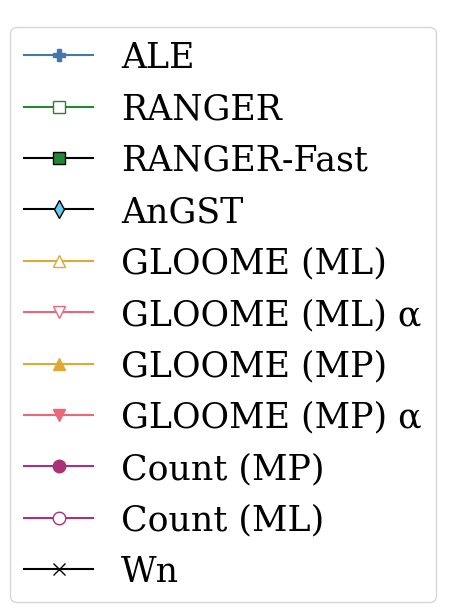

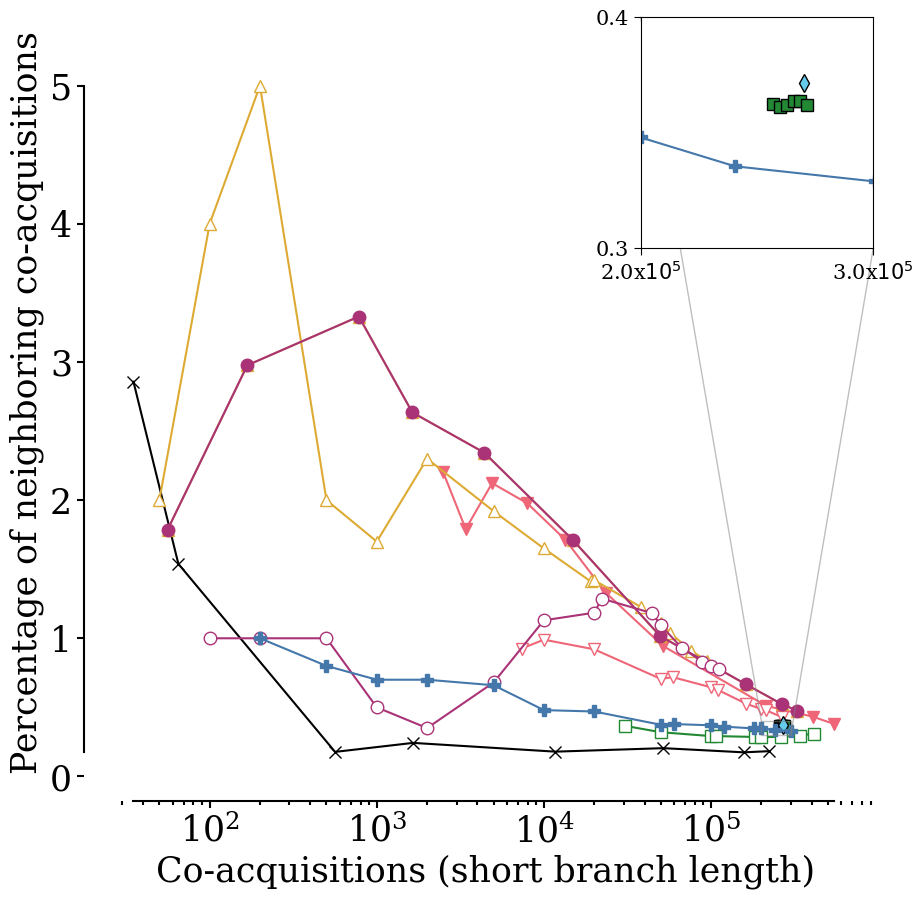

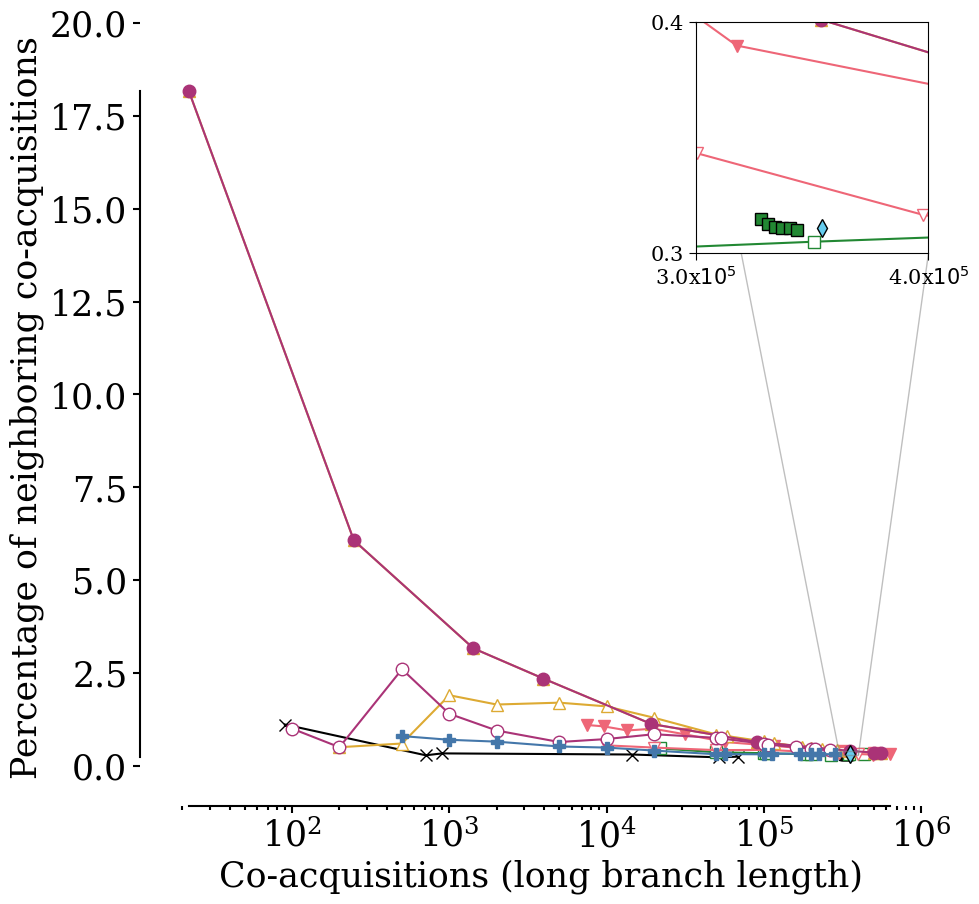

In [10]:
# plot just the legend without any plot
fig, ax = plt.subplots(figsize=(1, 5))
for sm_key in marker_styles_dict.keys():
    if type(marker_styles_dict[sm_key]) is dict:
        method = sm_key
        ax.plot(
            [],
            [],
            marker=marker_styles_dict[method]["marker_pyplot"],
            color=marker_styles_dict[method]["marker_color"],
            markerfacecolor=marker_styles_dict[method]["face_color"],
            label=marker_styles_dict[method]["label"],
        )
ax.legend()
ax.axis("off")
plt.savefig(f"{plots_dir}/legend_tall.jpg", bbox_inches="tight", dpi=300)
plt.show()

# Plot the percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(10, 10))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[2e5, 3e5]]
y_inset_lims = [[0.3, 0.4]]
fig, ax = clsl.plot_multiple_figs_with_insets(
    fig,
    [ax],
    {
        "short branch length": binned_coacq_by_branch_length_dfs["short branches"]
    },
    "coacquisitions with known positions",
    "neighbor (max 1 intervening genes) percentage",
    marker_styles_dict,
    x_inset_lims,
    y_inset_lims,
    "Co-acquisitions",
    "Percentage of neighboring co-acquisitions",
    insets,
)
plt.savefig(
    f"{plots_dir}/neighboring_coacq_short_branch_length.jpg", bbox_inches="tight", dpi=300,
)
plt.show()
# fig, ax = plt.subplots(figsize=(10, 10))
# x_inset_lims = [[1.5e5, 1.8e5]]
# y_inset_lims = [[0.3, 0.4]]
# fig, ax = clsl.plot_multiple_figs_with_insets(
#     fig,
#     [ax],
#     {
#         "medium branch length": binned_coacq_by_branch_length_dfs["medium branches"]
#     },
#     "coacquisitions with known positions",
#     "neighbor (max 1 intervening genes) percentage",
#     marker_styles_dict,
#     x_inset_lims,
#     y_inset_lims,
#     "Co-acquisitions",
#     "Percentage of neighboring co-acquisitions",
#     insets,
# )
# plt.savefig(
#     f"{plots_dir}/neighboring_coacq_medium_branch_length.jpg", bbox_inches="tight", dpi=300,
# )
# plt.show()
fig, ax = plt.subplots(figsize=(10, 10))
x_inset_lims = [[3e5, 4e5]]
y_inset_lims = [[0.3, 0.4]]
fig, ax = clsl.plot_multiple_figs_with_insets(
    fig,
    [ax],
    {"long branch length": binned_coacq_by_branch_length_dfs["long branches"]},
    "coacquisitions with known positions",
    "neighbor (max 1 intervening genes) percentage",
    marker_styles_dict,
    x_inset_lims,
    y_inset_lims,
    "Co-acquisitions",
    "Percentage of neighboring co-acquisitions",
    insets,
)
plt.savefig(
    f"{plots_dir}/neighboring_coacq_long_branch_length.jpg", bbox_inches="tight", dpi=300,
)
plt.show()


GLOOME MP and Count MP agree completely. GLOOME ML>Count ML unless it's long branches. In fact Count ML severely underperforms with short branches.

In [12]:
# for each bin_df, find the mean of the corrected percentage of neighboring coacquisitions

agg_var = "neighbor (max 1 intervening genes) percentage"
ranked_method_mean_performance_dfs_dict = {}
for bin_name, bin_df in binned_coacq_by_branch_length_dfs.items():
    print(f"Processing {bin_name} bin")
    # first remove from bin_df any of the rows where the number of coacquisitions is < 1e3 and > 1e5
    bin_df = bin_df[(bin_df["coacquisitions with known positions"] >= 1e3) & (bin_df["coacquisitions with known positions"] <= 1e5)]
    # for each method, find the mean of the corrected percentage of neighboring coacquisitions
    #     ...for each method. Groupby method,
    #     and find max of the transfer threshold
    #     value of mean of observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)
    #     and std of the values across the transfer thresholds
    percentage_binned_df = bin_df.groupby("method"
        ).agg(
        {
            agg_var: [
                "mean",
                "std",
                lambda x: x.idxmax(),
                lambda x: x.max(),
            ]
        }
    ).reset_index()
    percentage_binned_df.columns = [
        "Method",
        "Mean",
        "Std",
        "Max IDX",
        "Max",
    ]
    percentage_binned_df["Stringency"] = bin_df.loc[
        percentage_binned_df["Max IDX"]
    ]["transfer threshold"].values
    percentage_binned_df = percentage_binned_df.drop(
        columns=["Max IDX"]
    )
    # sort descending by Mean
    percentage_binned_df = percentage_binned_df.sort_values(
        by="Mean", ascending=False
    )
    # replace NaN with 'NA'
    percentage_binned_df = percentage_binned_df.fillna("NA")
    # show the dataframe
    display(percentage_binned_df)

    # replace method names with the 'label' from marker_styles_dict[method]['label']
    percentage_binned_df["Method"] = percentage_binned_df["Method"].apply(
        lambda x: marker_styles_dict[x]["label"] if x in marker_styles_dict else x
    )

    # add the df to the ranked_method_mean_performance_dfs_dict
    ranked_method_mean_performance_dfs_dict[bin_name] = percentage_binned_df

# combine dfs in the ranked_method_mean_performance_dfs_dict into a single df
## with a header row for each bin type
# Prepare multi-row header

# Get the number of methods per bin (should be the same for both bins)
n_methods = [len(df) for df in ranked_method_mean_performance_dfs_dict.values()]

# Build the multi-row columns
columns = []
for bin_name, df in ranked_method_mean_performance_dfs_dict.items():
    columns.extend([(bin_name, "Method"), (bin_name, "Mean")])

# Build the data for the table
data = []
for i in range(max(n_methods)):
    row = []
    for bin_name, df in ranked_method_mean_performance_dfs_dict.items():
        if i < len(df):
            row.extend([df.iloc[i, 0], df.iloc[i, 1]])
        else:
            row.extend([np.nan, np.nan])
    data.append(row)

multi_index = pd.MultiIndex.from_tuples(columns)
ranked_method_mean_performance_table = pd.DataFrame(data, columns=multi_index)

# Display the table
display(ranked_method_mean_performance_table)
# display latex
print(
    ranked_method_mean_performance_table.to_latex(
        index=False, float_format="%.3f"
    ).replace("NaN", "")
)

Processing short branches bin


,Method,Mean,Std,Max,Stringency
2,count.mp,1.926534,0.718971,2.634804,5.00000
5,gloome.mp,1.926534,0.718971,2.634804,5.00000
6,gloome.mp.without_tree,1.725659,0.450583,2.200000,8.00000
3,gloome.ml,1.410879,0.451470,2.300000,0.96120
1,count.ml,0.905961,0.304671,1.287013,0.90103
4,gloome.ml.without_tree,0.817516,0.144165,0.990000,0.97780
0,ale,0.516635,0.147398,0.700000,0.78000
7,ranger,0.326052,0.037447,0.366157,1.00000
8,wn,0.208883,0.031903,0.242718,7.00000


Processing long branches bin


,Method,Mean,Std,Max,Stringency
2,count.mp,1.820171,1.147707,3.162333,5.000000
5,gloome.mp,1.820171,1.147707,3.162333,5.000000
3,gloome.ml,1.305296,0.479244,1.900000,0.979700
6,gloome.mp.without_tree,0.933437,0.168480,1.099933,8.000000
1,count.ml,0.830176,0.256207,1.400000,0.999964
4,gloome.ml.without_tree,0.488408,0.063550,0.553042,1.000000
0,ale,0.462872,0.154577,0.700000,0.750000
7,ranger,0.390763,0.069145,0.469289,1.000000
8,wn,0.259038,0.039742,0.303637,5.000000


short branches            long branches          
          Method      Mean         Method      Mean
0     Count (MP)  1.926534     Count (MP)  1.820171
1    GLOOME (MP)  1.926534    GLOOME (MP)  1.820171
2  GLOOME (MP) α  1.725659    GLOOME (ML)  1.305296
3    GLOOME (ML)  1.410879  GLOOME (MP) α  0.933437
4     Count (ML)  0.905961     Count (ML)  0.830176
5  GLOOME (ML) α  0.817516  GLOOME (ML) α  0.488408
6            ALE  0.516635            ALE  0.462872
7         RANGER  0.326052         RANGER  0.390763
8             Wn  0.208883             Wn  0.259038

\begin{tabular}{lrlr}
\toprule
\multicolumn{2}{r}{short branches} & \multicolumn{2}{r}{long branches} \\
Method & Mean & Method & Mean \\
\midrule
Count (MP) & 1.927 & Count (MP) & 1.820 \\
GLOOME (MP) & 1.927 & GLOOME (MP) & 1.820 \\
GLOOME (MP) α & 1.726 & GLOOME (ML) & 1.305 \\
GLOOME (ML) & 1.411 & GLOOME (MP) α & 0.933 \\
Count (ML) & 0.906 & Count (ML) & 0.830 \\
GLOOME (ML) α & 0.818 & GLOOME (ML) α & 0.488 \\
ALE & 0.517 & ALE & 0.463 \\
RANGER & 0.326 & RANGER & 0.391 \\
Wn & 0.209 & Wn & 0.259 \\
\bottomrule
\end{tabular}

